# Diabetes
I have found this dataset on Kaggle on the URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database. I will do my best to analyze it.

## Imports

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

from sklearn.preprocessing import StandardScaler


## Load

In [143]:
df = pd.read_csv('./data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploring our data

In [144]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Looks like features are in the expected type, except Outcome - it should be boolean, not int64.

In [146]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [147]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No missing data!

In [148]:
for col in df.columns:
    print(f'Number of unique values for {col} are: {len(df[col].unique())}')

Number of unique values for Pregnancies are: 17
Number of unique values for Glucose are: 136
Number of unique values for BloodPressure are: 47
Number of unique values for SkinThickness are: 51
Number of unique values for Insulin are: 186
Number of unique values for BMI are: 248
Number of unique values for DiabetesPedigreeFunction are: 517
Number of unique values for Age are: 52
Number of unique values for Outcome are: 2


Everything looks okay. Outcome has only 2 uniques values - which is what we expect.

In [149]:
value_counts = df['Outcome'].value_counts().T
value_counts

Outcome
0    500
1    268
Name: count, dtype: int64

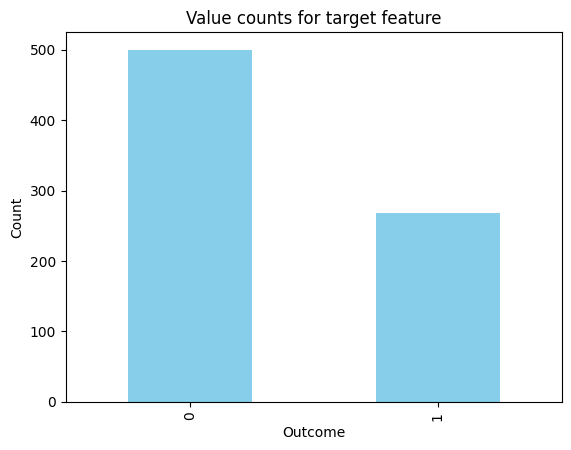

In [150]:
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value counts for target feature')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

As we can see target feature is not balanced. This means that we should account for it - using the right algorithms and metrics to assess performance.

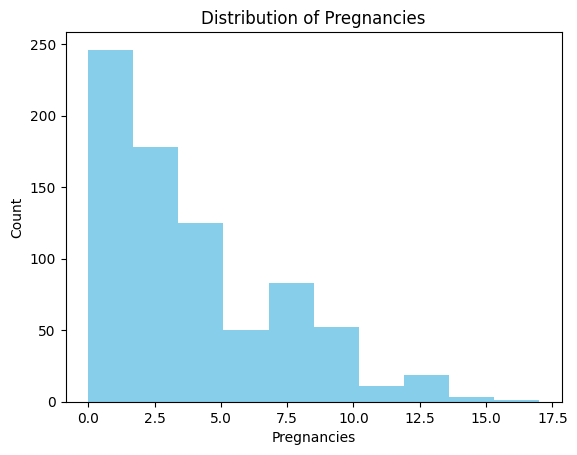

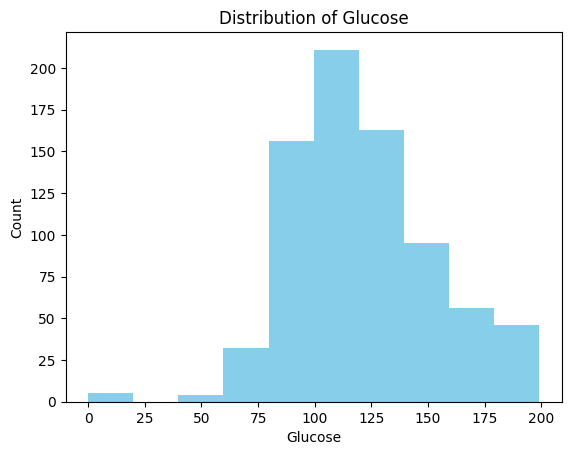

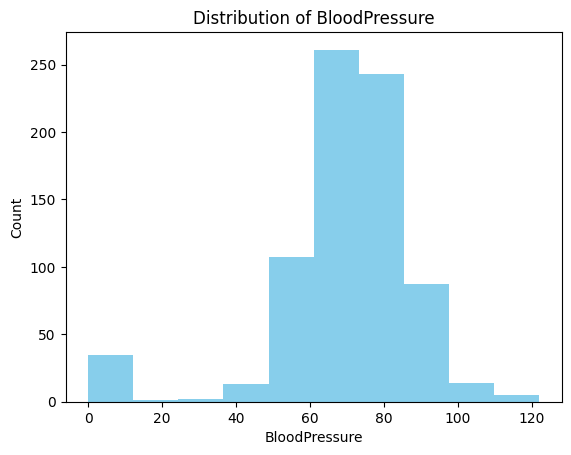

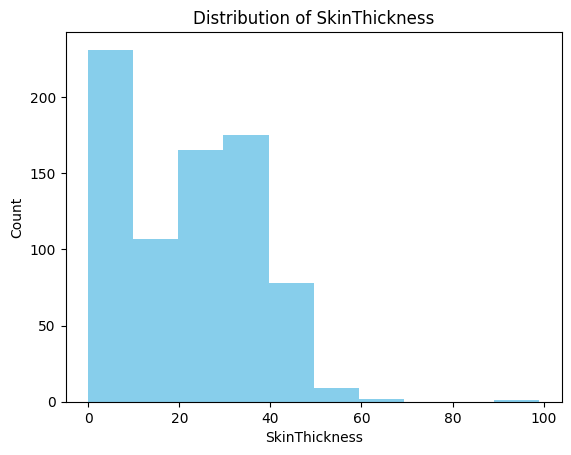

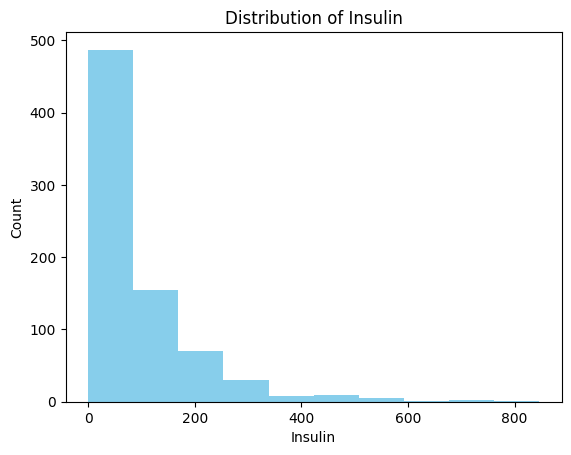

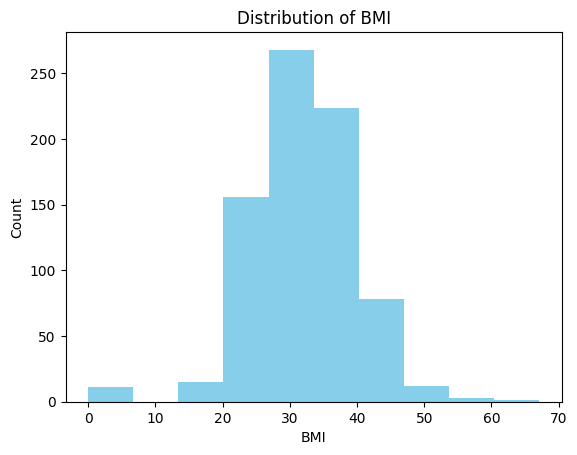

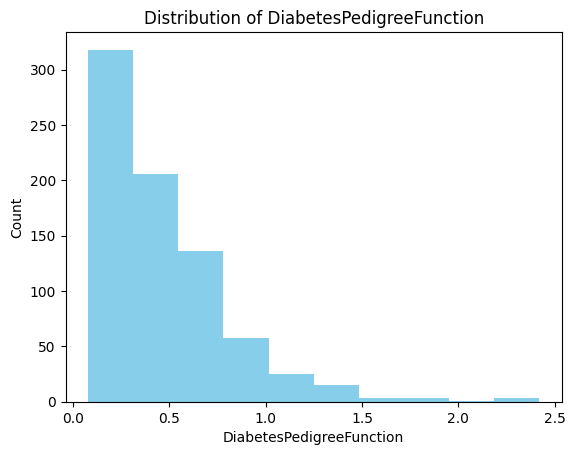

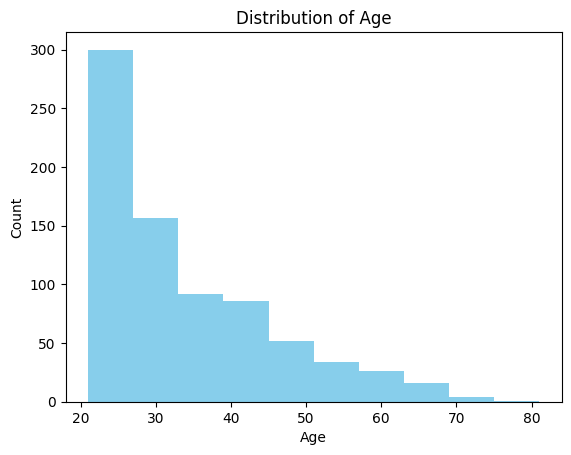

In [151]:
for col in df.columns.drop('Outcome'):
    plt.hist(df[col], color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

We can see that some of the values are zeros which is most likely not accurate. For example it is impossible to have blood pressure of 0.

In [152]:
for col in df.columns.drop('Outcome'):
    print(f'Number of zeros in: {col} are {(df[col] == 0).sum()}.')

Number of zeros in: Pregnancies are 111.
Number of zeros in: Glucose are 5.
Number of zeros in: BloodPressure are 35.
Number of zeros in: SkinThickness are 227.
Number of zeros in: Insulin are 374.
Number of zeros in: BMI are 11.
Number of zeros in: DiabetesPedigreeFunction are 0.
Number of zeros in: Age are 0.


There are some problems. BMI of 0 and blood pressure of 0 are impossible to have. 

In [153]:
invalid_rows = ((df['BloodPressure'] == 0) | (df['BMI'] == 0)).sum()
invalid_rows

39

In [154]:
invalid_rows / len(df)

0.05078125

5% of the rows are have some invalid data in them. I think it is okay to remove them.

In [155]:
df = df[(df['BloodPressure'] != 0) & (df['BMI'] != 0)]
len(df)

729

## EDA

In [156]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

<Axes: xlabel='BMI', ylabel='Age'>

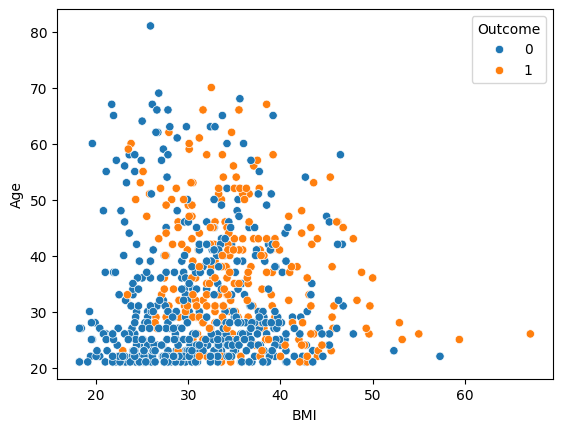

In [157]:
sns.scatterplot(data=df, x='BMI', y='Age', hue='Outcome')

In [158]:
df['BMI'].corr(df['Age'])

0.024689454386998665

Easy to see that older + high BMI = bigger chance of having diabetes.

<Axes: xlabel='BMI', ylabel='BloodPressure'>

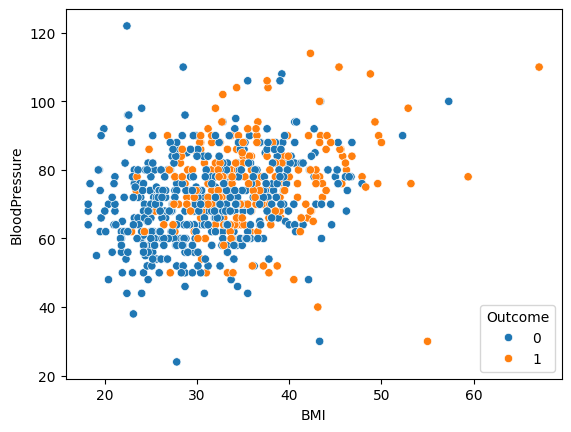

In [159]:
sns.scatterplot(data=df, x='BMI', y='BloodPressure', hue='Outcome')

In [160]:
df['BMI'].corr(df['BloodPressure'])

0.28923034040466655

<Axes: xlabel='Insulin', ylabel='BloodPressure'>

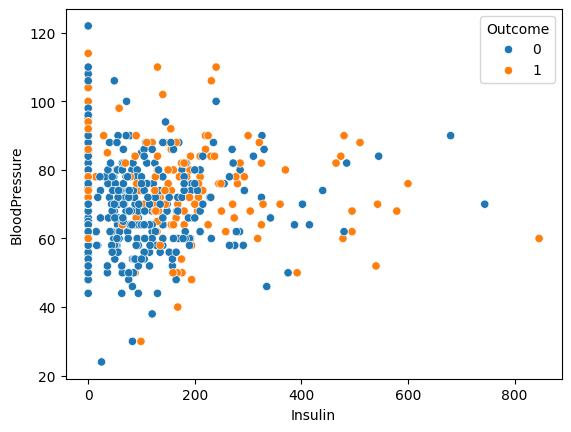

In [161]:
sns.scatterplot(data=df, x='Insulin', y='BloodPressure', hue='Outcome')

In [162]:
df['Insulin'].corr(df['BloodPressure'])

-0.04468445411598436

There isn't any evidence that insulin and blood pressure are correlated. 
On the other hand there is a lot of data that suggest that people with 0 insulin don't have diabetes, which is wrong?

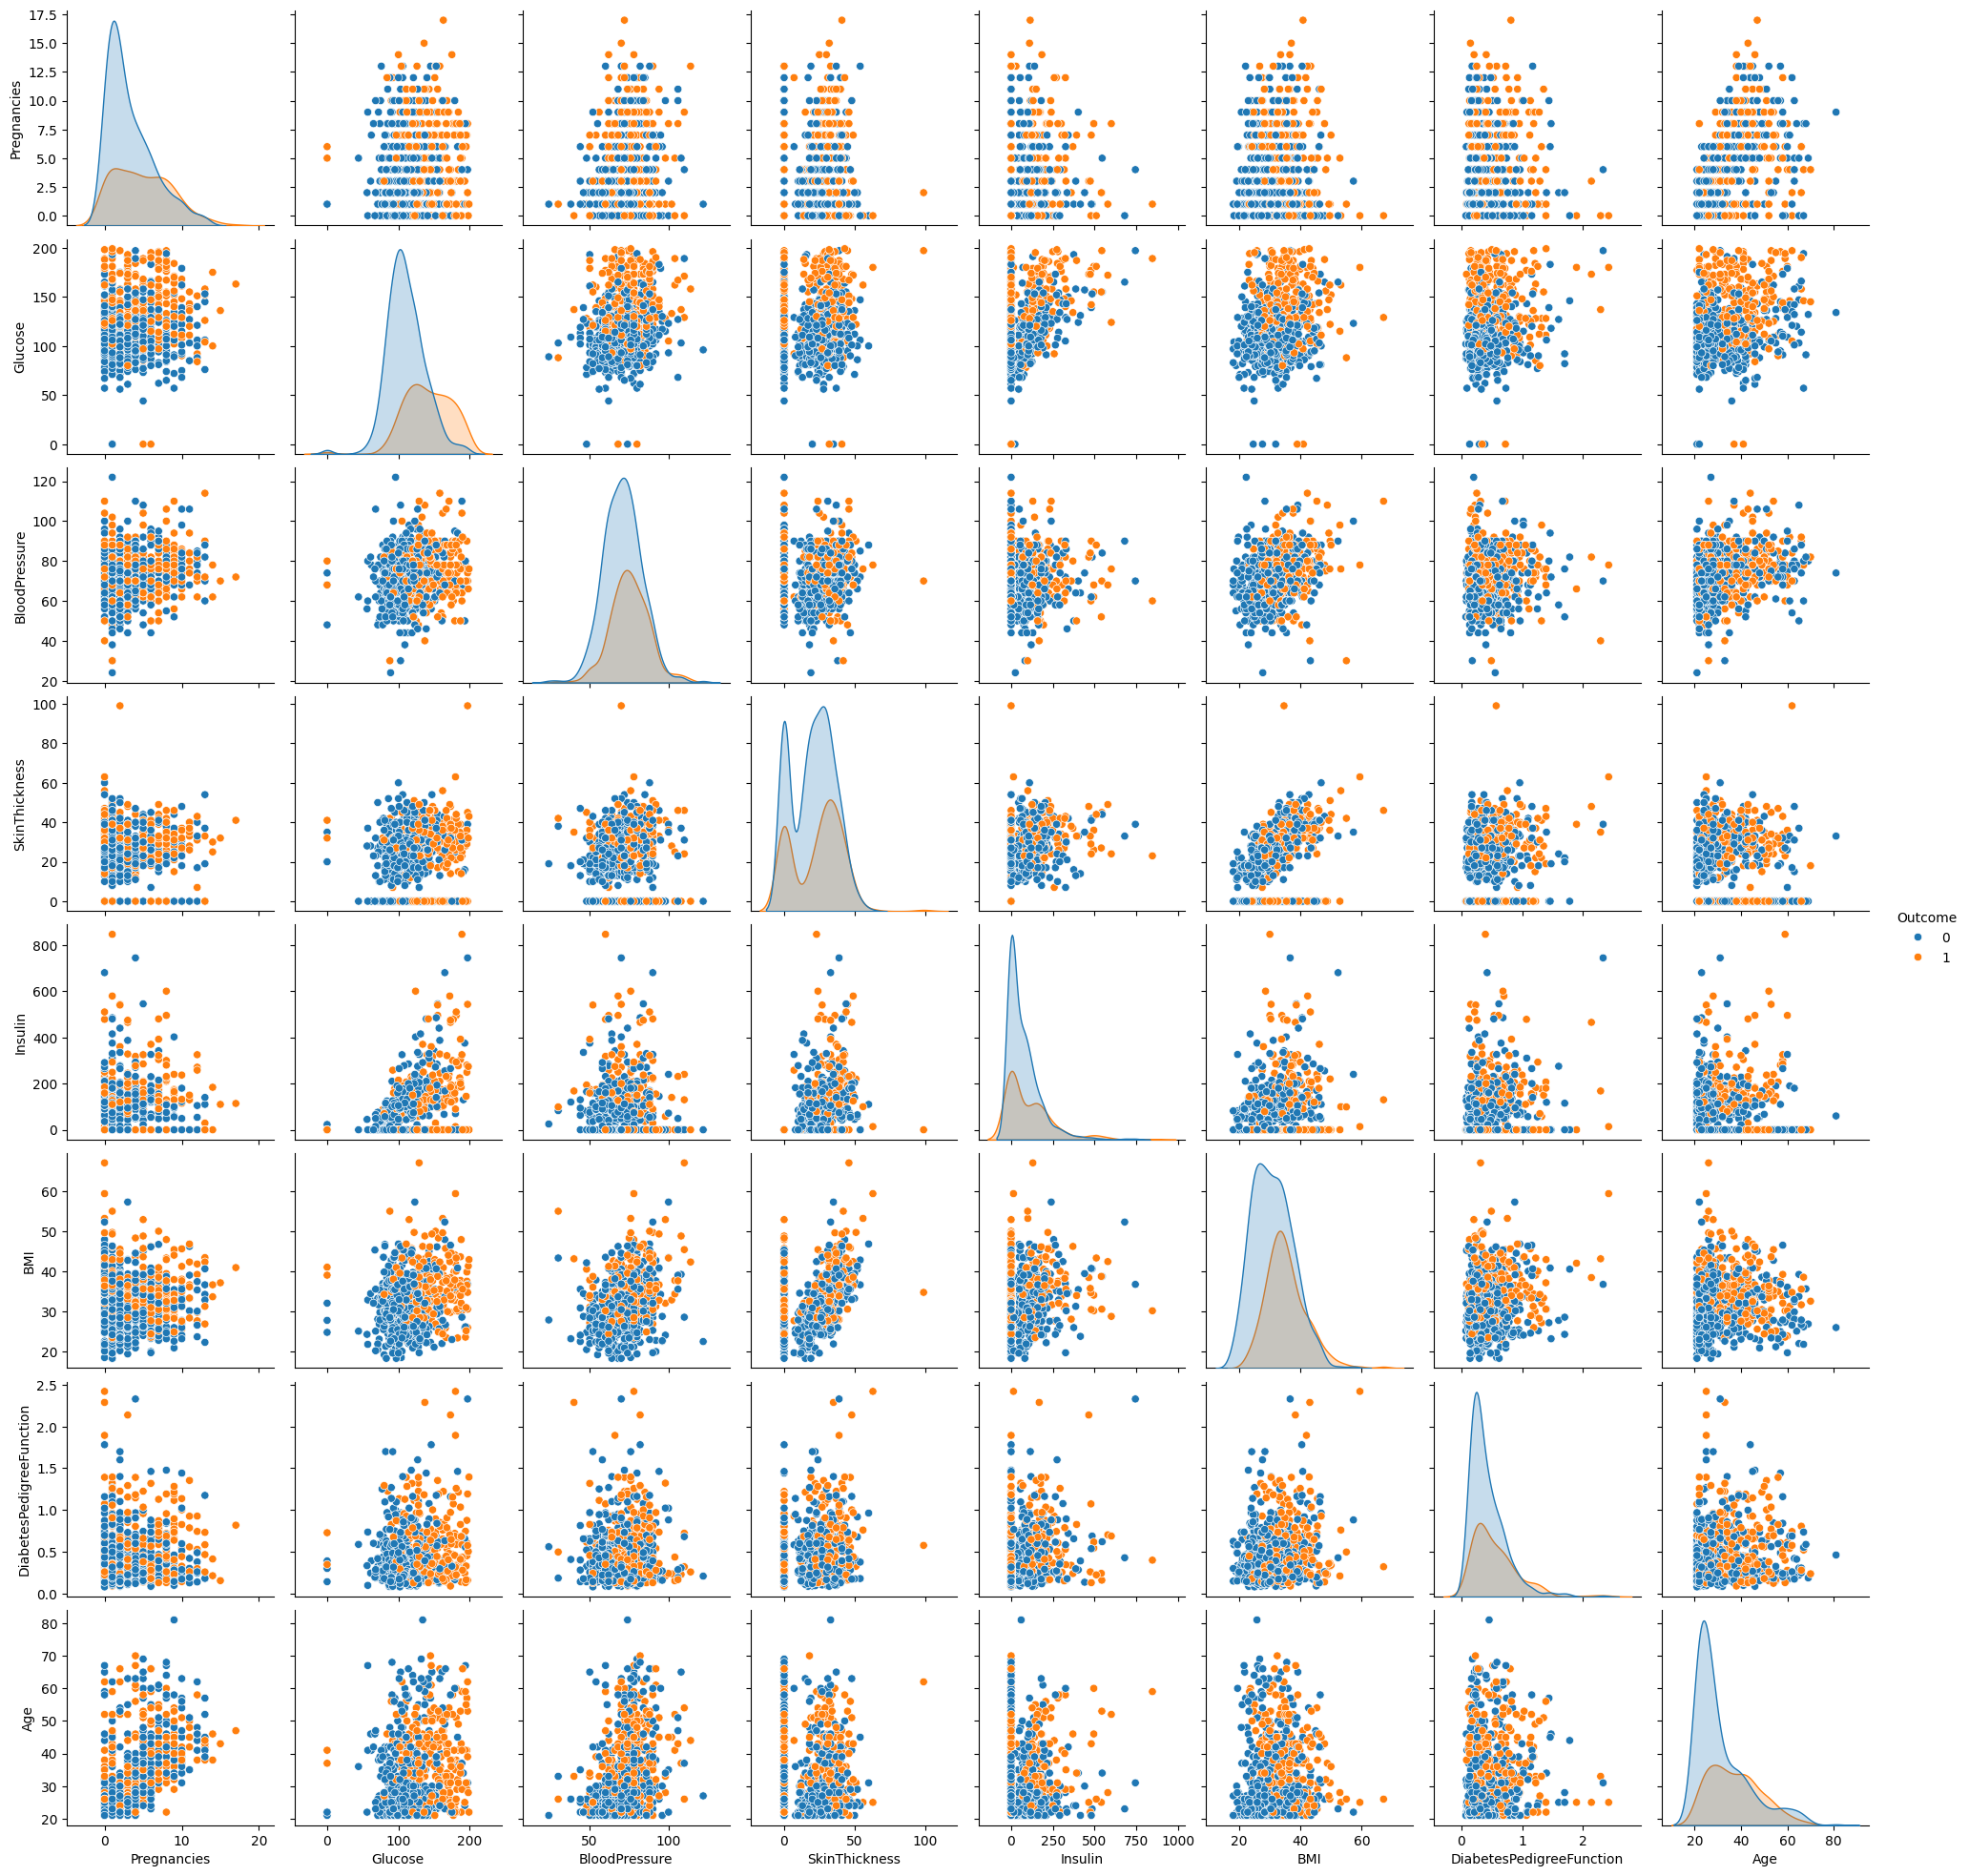

In [163]:
sns.pairplot(df, hue='Outcome')

We can easily see that levels of glucose in the blood is a very strong predictor of diabetes.

In [164]:
df['Glucose'].corr(df['Outcome'])

0.4592355518959858

<Axes: xlabel='BMI', ylabel='Glucose'>

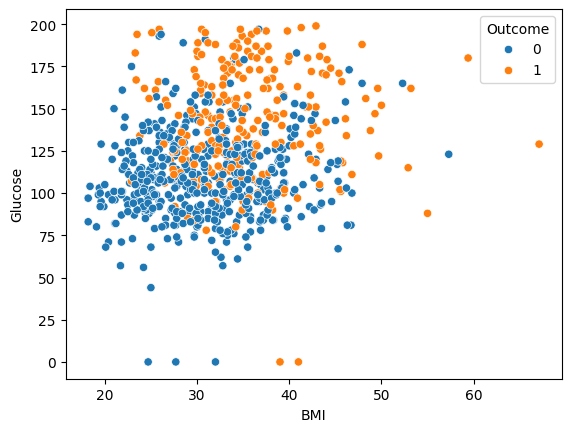

In [165]:
sns.scatterplot(df, x='BMI', y='Glucose', hue='Outcome')

## Data prepartation

In [166]:
df['Outcome'] = df['Outcome'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               729 non-null    int64  
 1   Glucose                   729 non-null    int64  
 2   BloodPressure             729 non-null    int64  
 3   SkinThickness             729 non-null    int64  
 4   Insulin                   729 non-null    int64  
 5   BMI                       729 non-null    float64
 6   DiabetesPedigreeFunction  729 non-null    float64
 7   Age                       729 non-null    int64  
 8   Outcome                   729 non-null    bool   
dtypes: bool(1), float64(2), int64(6)
memory usage: 52.0 KB


## Splitting data

In [167]:
y = df['Outcome']
X = df[df.columns.drop(['Outcome'])]
X, y

(     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0              6      148             72             35        0  33.6   
 1              1       85             66             29        0  26.6   
 2              8      183             64              0        0  23.3   
 3              1       89             66             23       94  28.1   
 4              0      137             40             35      168  43.1   
 ..           ...      ...            ...            ...      ...   ...   
 763           10      101             76             48      180  32.9   
 764            2      122             70             27        0  36.8   
 765            5      121             72             23      112  26.2   
 766            1      126             60              0        0  30.1   
 767            1       93             70             31        0  30.4   
 
      DiabetesPedigreeFunction  Age  
 0                       0.627   50  
 1                    

In [168]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.638207,0.836202,-0.029726,0.860048,-0.719195,0.164241,0.461296,1.420327
1,-0.852033,-1.118312,-0.514874,0.477824,-0.719195,-0.853145,-0.371481,-0.197381
2,1.234303,1.922043,-0.676590,-1.369593,-0.719195,-1.332770,0.597075,-0.112239
3,-0.852033,-0.994216,-0.514874,0.095600,0.086131,-0.635134,-0.926665,-1.048806
4,-1.150081,0.494937,-2.617184,0.860048,0.720112,1.544980,5.473043,-0.027096


In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((510, 8), (219, 8))

## Modelling

In [170]:
results = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'F1 Score': []
})
results

,Model,Accuracy,Precision,F1 Score


In [171]:
lr = LogisticRegression();
lr.fit(X_train, y_train)

LogisticRegression()

In [172]:
pred = lr.predict(X_test)
pred[:10]

array([ True, False,  True,  True,  True, False, False,  True, False,
        True])

In [173]:
confusion = confusion_matrix(y_test, pred)
confusion

array([[125,  15],
       [ 32,  47]])

In [174]:
results = pd.concat([results, pd.DataFrame({
        'Model': ['Logistic regression'],
    'Accuracy': [accuracy_score(y_test, pred)],
    'Precision': [precision_score(y_test, pred)],
    'F1 Score': [f1_score(y_test, pred)]
})])

In [175]:
results

,Model,Accuracy,Precision,F1 Score
0,Logistic regression,0.785388,0.758065,0.666667


As expected accuracy is high, but the dataset is unbalanced so we should look for the harmonic mean between accuracy and precision: the f1-score.

In [179]:
k = 5
knn = KNeighborsClassifier(k)
knn.fit(X_train, y_train)
knn

KNeighborsClassifier()

In [181]:
pred = knn.predict(X_test)
pred[:10]

array([False, False,  True,  True,  True, False, False, False, False,
       False])

In [182]:
results = pd.concat([results, pd.DataFrame({
        'Model': ['KNN'],
    'Accuracy': [accuracy_score(y_test, pred)],
    'Precision': [precision_score(y_test, pred)],
    'F1 Score': [f1_score(y_test, pred)]
})])

In [183]:
results

,Model,Accuracy,Precision,F1 Score
0,Logistic regression,0.785388,0.758065,0.666667
0,KNN,0.735160,0.672131,0.585714


## Understanding the models

In [210]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_[0]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df

,Feature,Coefficient
1,Glucose,0.992034
5,BMI,0.646536
0,Pregnancies,0.375437
6,DiabetesPedigreeFunction,0.358431
7,Age,0.151560
3,SkinThickness,-0.076427
4,Insulin,-0.104533
2,BloodPressure,-0.196385


We can see that levels of glucose in the blood stream is by far the biggest predictor of diabetes, but also BMI, number of pregnancies, pedigree function and blood pressure. It is important to say that logistic regression is a linear model which means that the relationships it finds between the data and the target feature are linear. It is possible that the data is following other - non linear patterns and this model is blind for such patterns.